### Chinese characters

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from skimage.transform import resize

from keras.models import Sequential
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.layers.advanced_activations import PReLU
from keras.layers.convolutional import Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

%matplotlib inline

Using TensorFlow backend.


Attention! All calculations were conducted on a machine with sufficient RAM amount. That's why train and test data sets are always stored in memory.

In [2]:
train = np.load('train.npy')
test = np.load('test.npy')

Now we split our data set  into training and validation parts.

In [3]:
#train, validation = train_test_split(train, test_size=0.1, stratify=train[: , 1]) 

Now we need prepare images. First, we quadratise images.

In [4]:
def quadratize(img):
    height, width = img.shape

    if height > width:
        result = np.zeros(shape=(height, height), dtype=img.dtype)
        margin = (height - width) // 2
        result[:, margin: width + margin] = img
        return result
        
    if height < width:
        result = np.zeros(shape=(width, width), dtype=img.dtype)
        margin = (width - height) // 2
        result[margin: margin + height, :] = img
        return result

    return img

Then we cast our matrix to float16 and invert each pixel value (pixels of background are zeros now).

In [5]:
def normalize(img):
    img -= img.min()
    return 1 - img.astype(np.float16) / img.max()

At the end we resize our images to $64 \times 64$.

In [6]:
size = 64

In [7]:
def process(img, size):    
    img = quadratize(normalize(img))
    
    img_size = img.shape[0]
    
    if img_size > size:
        return resize(img, output_shape=(size, size)).astype(img.dtype)
   
    if img_size < size:
        result = np.zeros(shape=(size, size), dtype=img.dtype)
        margin = (size - img_size) // 2
        result[margin: margin + img_size, margin: margin + img_size] = img
        return result

    return img

In [8]:
def prepare(X):
    X = np.array([process(x, size) for x in X])
    return X.reshape(*X.shape, 1)

In [9]:
X_train = prepare(train[:, 0])
#X_valid = prepare(validation[:, 0])
X_test = prepare(test)

Few examples of processing:

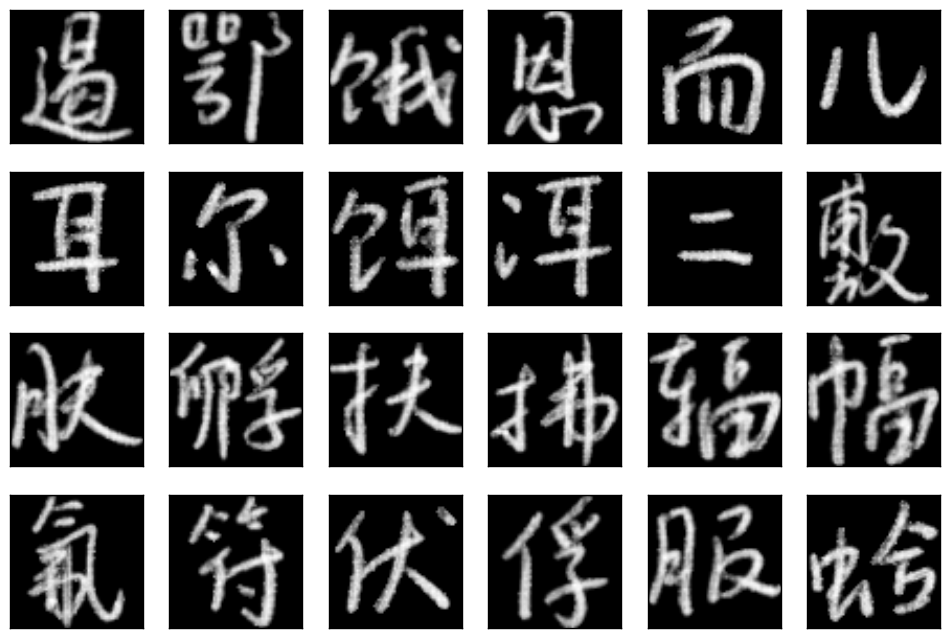

In [10]:
row_n, col_n = 4, 6

fig = plt.figure(figsize=(2 * col_n, 2 * row_n))
for sample_n in range(1, col_n * row_n + 1):
    ax = fig.add_subplot(row_n, col_n, sample_n)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(X_train[sample_n, :, :, 0], cmap="gray")

Let's prepare our labels.

In [11]:
class Encoder:
    def __init__(self, codes):
        self.code_to_label_ = dict()
        self.label_to_code_ = dict()
        for label, code in enumerate(set(codes), 0):
            self.code_to_label_[code] = label
            self.label_to_code_[label] = code
    
    def size(self):
        return len(self.code_to_label_)


    
    def labels(self, codes):
        return np_utils.to_categorical(
            [self.code_to_label_[code] for code in codes],
            self.size()
        )
    
    def codes(self, labels):
        return np.array(
            [self.label_to_code_[np.argmax(label)] for label in labels]
        )
        
    
encoder = Encoder(train[:, 1])

In [12]:
Y_train = encoder.labels(train[:, 1])
#Y_valid = encoder.labels(validation[:, 1])

And helper to save result.

In [13]:
def to_csv(path, y_pred):
    with open(path, 'w') as out:
        print('Id,Category', file=out)
        for i, category in enumerate(y_pred, 1):
            print('{i},{category}'.format(i=i, category=category), file=out)

### Learning:

In [14]:
generator = ImageDataGenerator(
    fill_mode = 'constant',
    cval = 0,
    rotation_range = 10,
    width_shift_range = 0.10,
    height_shift_range = 0.10,
    zoom_range = 0.10
)
generator.fit(X_train)

In [15]:
model = Sequential()

model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode='same', input_shape=(size, size, 1))) # 64->32
model.add(PReLU())
model.add(BatchNormalization(axis=3))

model.add(Convolution2D(64, 5, 5, subsample=(2, 2))) # 32->16
model.add(PReLU())
model.add(BatchNormalization(axis=3))

model.add(Convolution2D(64, 7, 7, subsample=(2, 2), border_mode='same')) #16->8
model.add(PReLU())
model.add(BatchNormalization(axis=3))  

model.add(Convolution2D(128, 7, 7, subsample=(2, 2), border_mode='same')) #8->4
model.add(PReLU())
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(500))
model.add(Activation('softmax'))

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
);

In [16]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 32, 32)    832         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
prelu_1 (PReLU)                  (None, 32, 32, 32)    32768       convolution2d_1[0][0]            
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 32, 32, 32)    64          prelu_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 14, 64)    51264       batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [18]:
model.fit_generator(
    generator.flow(X_train, Y_train, batch_size=64),
    samples_per_epoch=len(X_train),
    nb_epoch = 8,
    verbose = 1#,
#    validation_data = (X_valid, Y_valid)
)

Epoch 1/8
166708/166708 [==============================] - 449s - loss: 1.5051 - acc: 0.6489   
Epoch 2/8
166708/166708 [==============================] - 447s - loss: 0.4895 - acc: 0.8635   
Epoch 3/8
166708/166708 [==============================] - 450s - loss: 0.3647 - acc: 0.8968   
Epoch 4/8
166708/166708 [==============================] - 452s - loss: 0.2983 - acc: 0.9140   
Epoch 5/8
166708/166708 [==============================] - 453s - loss: 0.2559 - acc: 0.9247   
Epoch 6/8
166708/166708 [==============================] - 450s - loss: 0.2255 - acc: 0.9338   
Epoch 7/8
166708/166708 [==============================] - 451s - loss: 0.2035 - acc: 0.9400   
Epoch 8/8
166708/166708 [==============================] - 451s - loss: 0.1880 - acc: 0.9439   


In [19]:
model.fit_generator(
    generator.flow(X_train, Y_train, batch_size=512),
    samples_per_epoch=len(X_train),
    nb_epoch = 3,
    verbose = 1#,
#    validation_data = (X_valid, Y_valid)
)

Epoch 1/3
166708/166708 [==============================] - 425s - loss: 0.1242 - acc: 0.9623   
Epoch 2/3
166708/166708 [==============================] - 426s - loss: 0.1051 - acc: 0.9684   
Epoch 3/3
166708/166708 [==============================] - 426s - loss: 0.0963 - acc: 0.9706   


In [20]:
model.fit_generator(
    generator.flow(X_train, Y_train, batch_size=2048),
    samples_per_epoch=len(X_train),
    nb_epoch = 3,
    verbose = 1#,
#    validation_data = (X_valid, Y_valid)
)

Epoch 1/3
166708/166708 [==============================] - 430s - loss: 0.0863 - acc: 0.9738   
Epoch 2/3
166708/166708 [==============================] - 430s - loss: 0.0826 - acc: 0.9747   
Epoch 3/3
166708/166708 [==============================] - 429s - loss: 0.0782 - acc: 0.9759   


In [21]:
model.fit_generator(
    generator.flow(X_train, Y_train, batch_size=8192),
    samples_per_epoch=len(X_train),
    nb_epoch = 3,
    verbose = 1#,
#    validation_data = (X_valid, Y_valid)
)

Epoch 1/3
166708/166708 [==============================] - 430s - loss: 0.0759 - acc: 0.9768   
Epoch 2/3
166708/166708 [==============================] - 426s - loss: 0.0770 - acc: 0.9763   
Epoch 3/3
166708/166708 [==============================] - 424s - loss: 0.0763 - acc: 0.9766   


In [22]:
Y_pred = model.predict(X_test)

In [43]:
y_pred = encoder.codes(Y_pred)
to_csv('prediction.csv', y_pred)